In [73]:
import os
import math
import numpy as np
import pandas as pd
import librosa

import torch
import torch.nn as nn
import torchaudio
from torchvision import models

import matplotlib.pyplot as plt

In [74]:
# configurations

DATA_DIR = "./data/UrbanSound8K"
MODEL_DIR = "./model/model-b"
MODEL_FILE = "vgg13_b_fold1.pth"

SAMPLE_RATE = 22050
CLIP_DURATION = 4.0
N_MELS = 128
FMIN = 0
FMAX = SAMPLE_RATE // 2
N_CLASSES = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Class names for UrbanSound8K (classID 0-9)
CLASS_NAMES = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

Using device: cpu


In [75]:
# dataset (no augmentation, used only to load one sample)

class UrbanSound8KWaveDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_dir: str,
        folds=None,
        sample_rate: int = SAMPLE_RATE,
        duration: float = CLIP_DURATION,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_samples = int(sample_rate * duration)

        if folds is None:
            folds = list(range(1, 11))
        if isinstance(folds, int):
            folds = [folds]

        meta_path = os.path.join(data_dir, "metadata", "UrbanSound8K.csv")
        df = pd.read_csv(meta_path)
        self.df = df[df["fold"].isin(folds)].reset_index(drop=True)
        self.labels = self.df["classID"].astype(int).to_numpy()

    def __len__(self):
        return len(self.df)

    def _load_waveform(self, index: int) -> torch.Tensor:
        row = self.df.iloc[index]
        fold = row["fold"]
        fname = row["slice_file_name"]
        path = os.path.join(self.data_dir, "audio", f"fold{fold}", fname)

        # resample
        wav, sr = librosa.load(path, sr=self.sample_rate, mono=True)

        # pad / truncate to 4 seconds
        if len(wav) < self.n_samples:
            wav = np.pad(wav, (0, self.n_samples - len(wav)), mode="constant")
        elif len(wav) > self.n_samples:
            wav = wav[: self.n_samples]

        # normalization
        if np.std(wav) > 1e-6:
            wav = (wav - wav.mean()) / (wav.std() + 1e-6)

        wav = wav.astype(np.float32)
        return torch.from_numpy(wav).unsqueeze(0)  # [1, T]

    def __getitem__(self, index: int):
        x = self._load_waveform(index)
        y = int(self.labels[index])
        return x, torch.tensor(y, dtype=torch.long), index

In [76]:
# mel transformation (change waveform to mel spectrogram)

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=N_MELS,
    f_min=FMIN,
    f_max=FMAX,
    power=2.0,
).to(DEVICE)

db_transform = torchaudio.transforms.AmplitudeToDB().to(DEVICE)


def waveform_to_mel_single(x_wave: torch.Tensor) -> np.ndarray: # Convert one waveform [1, T] to a 2D log-mel spectrogram [n_mels, frames]
    x_wave = x_wave.to(DEVICE) # [1, T]
    x_in = x_wave.squeeze(0).unsqueeze(0)
    mel = mel_transform(x_in)
    mel_db = db_transform(mel)[0]
    mel_db = mel_db.cpu().numpy()
    return mel_db


def waveform_batch_to_mel_3ch(x_wave: torch.Tensor) -> torch.Tensor:
    x_in = x_wave.squeeze(1)
    mel = mel_transform(x_in)
    mel_db = db_transform(mel)
    mean = mel_db.mean(dim=(1, 2), keepdim=True)
    std = mel_db.std(dim=(1, 2), keepdim=True)
    mel_db = (mel_db - mean) / (std + 1e-6)
    mel_db = mel_db.unsqueeze(1)
    mel_db = mel_db.repeat(1, 3, 1, 1)
    return mel_db

In [77]:
# Model definition and loading

def create_pretrained_vgg13_b(num_classes: int = N_CLASSES) -> nn.Module:
    try:
        vgg = models.vgg13_bn(weights=models.VGG13_BN_Weights.IMAGENET1K_V1)
    except AttributeError:
        vgg = models.vgg13_bn(pretrained=True)

    in_features = vgg.classifier[-1].in_features
    vgg.classifier[-1] = nn.Linear(in_features, num_classes)
    return vgg


# Create model and load trained weights
model_path = os.path.join(MODEL_DIR, MODEL_FILE)
print("Loading model from:", model_path)

model = create_pretrained_vgg13_b(num_classes=N_CLASSES).to(DEVICE)
state_dict = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

Loading model from: ./model/model-b/vgg13_b_fold1.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [78]:
# Cell 6: Register hook on a convolutional layer

layer = 10
layer_to_visualize = model.features[layer]  # change index to visualize specific layers (first conv layer)
# layer_to_visualize = model.features[10]  # change index to visualize specific layers (deeper layer)

feature_maps = None

def hook_fn(module, input, output):
    global feature_maps
    feature_maps = output.detach()  # [B, C, H, W]

# Register the hook
hook_handle = layer_to_visualize.register_forward_hook(hook_fn)
print("Registered hook on layer:", layer_to_visualize)

Registered hook on layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [79]:
# Pick one sample and process

# choose a target class ID (0-9)
target_class_id = 4 # 4: Drilling

# Load dataset
dataset = UrbanSound8KWaveDataset(DATA_DIR, folds=None)

# Find the first sample with the target class
sample_idx = None
for i in range(len(dataset)):
    _, y, _ = dataset[i]
    if int(y.item()) == target_class_id:
        sample_idx = i
        break

if sample_idx is None:
    raise RuntimeError(f"No sample found for classID={target_class_id}")

print(f"Using sample index {sample_idx} from classID={target_class_id} ({CLASS_NAMES[target_class_id]})")

# Get waveform and label
waveform, label, _ = dataset[sample_idx]
print("Waveform shape:", waveform.shape, "Label:", label.item())

# Convert to mel-spectrogram for visualization (2d)
mel_2d = waveform_to_mel_single(waveform)  # [n_mels, frames]

# change to 3-channel mel for the model
wave_batch = waveform.unsqueeze(0).to(DEVICE)
mel_3ch_batch = waveform_batch_to_mel_3ch(wave_batch) # change to [1, 3, n_mels, frames]
with torch.no_grad():
    _ = model(mel_3ch_batch)
    
print("Captured feature map shape:", feature_maps.shape)

Using sample index 196 from classID=4 (drilling)
Waveform shape: torch.Size([1, 88200]) Label: 4
Captured feature map shape: torch.Size([1, 128, 64, 86])


target_class_id = 4 drilling
layer_index = 10


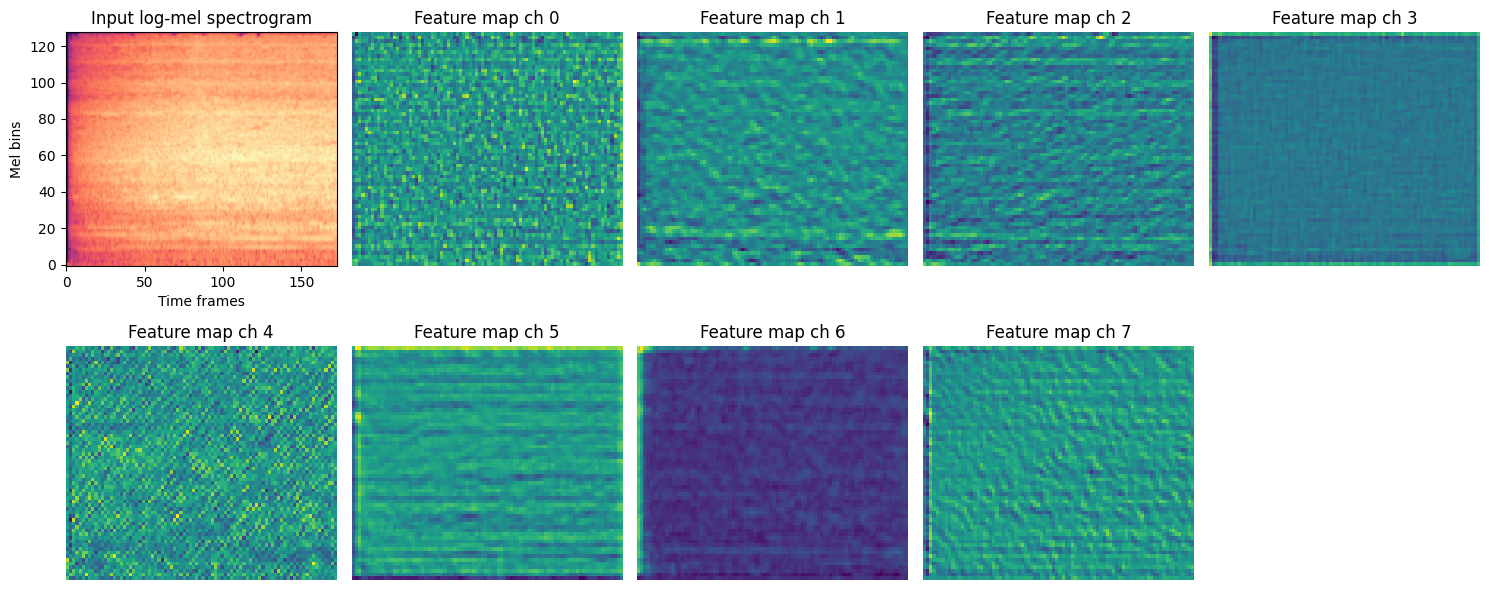

In [80]:
# Plot mel-spectrogram and feature maps

def plot_mel_and_feature_maps(mel_2d, feature_maps, num_channels_to_show=8):
    fm = feature_maps[0].cpu().numpy()
    C = fm.shape[0]
    num_channels_to_show = min(num_channels_to_show, C)

    # Total number of plots
    n_plots = 1 + num_channels_to_show
    rows = 2
    cols = math.ceil(n_plots / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    # plot original mel-spectrogram
    axes[0].imshow(mel_2d, origin="lower", aspect="auto", cmap="magma")
    axes[0].set_title("Input log-mel spectrogram")
    axes[0].set_xlabel("Time frames")
    axes[0].set_ylabel("Mel bins")

    print("target_class_id =",target_class_id, CLASS_NAMES[target_class_id])
    print("layer_index =",layer)
    # plot selected feature map channels
    for i in range(num_channels_to_show):
        ax = axes[i + 1]
        ax.imshow(fm[i], origin="lower", aspect="auto", cmap="viridis")
        ax.set_title(f"Feature map ch {i}")
        ax.axis("off")

    # hide any unused subplots
    for j in range(n_plots, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_mel_and_feature_maps(mel_2d, feature_maps, num_channels_to_show=8)